Simple logic:


*   load the two zipfiles
*   load the gadm data
*   load the city list

> HDX data seems to be clean, and two selections are needed, one spatial, based on the city list, and one temporal, based on the COVID-19 window. There are two files, and based on the window we need only the first one, or have to extend the data with the second file. 

> GADM data for france has 5 levels which have to be combined to create a logic, but inside the data there are join fields which can be used to create the hierarchical relations needed to go up and down in administravive levels.

> City Lists, there are two city lists; the first is the raw list coming from the main task, the second list is geocoded, this list will be used for the further processing of the movement data



In [1]:
# packages to install:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive

# for geospatial operations on dataframes
!pip install pandas fiona shapely pyproj rtree pygeo

# 
!pip install osmnx

!pip install geopandas
from geopandas.tools import sjoin


     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
     |████████████████████████████████| 994 kB 53.1 MB/s 
     |████████████████████████████████| 578 kB 63.3 MB/s 
     |████████████████████████████████| 561 kB 50.6 MB/s 
     |████████████████████████████████| 546 kB 32.3 MB/s 
     |████████████████████████████████| 532 kB 51.7 MB/s 
ERROR: Could not find a version that satisfies the requirement pygeo (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3)
ERROR: No matching distribution found for pygeo
     |████████████████████████████████| 93 kB 2.2 MB/s 
  Using cached Rtree-0.9.7-cp37-cp37m-manylinux2010_x86_64.whl (994 kB)
     |████████████████████████████████| 994 kB 31.4 MB/s 
     |████████████████████████████████| 10.3 MB 33.9 MB/s 
     |████████████████████████████████| 62 kB 969 kB/s 
  Using cached pyproj-3.1.0-cp37-cp37m-manylinux2010_x86_64.whl (6.6 MB)
  Using cached Fiona-1.8.20-cp37-cp37m-manylinux1_x86_64.whl

In [2]:
# Libaries needed:
import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd

import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline



In [3]:
#Creating the structure:

# Coming from Task 1:
city_list_GDRIVE = "https://drive.google.com/file/d/17sCrw7sZNwT4yE4wHK94sboi4X90DYwq/view?usp=sharing"

# GeoLocated names:
city_names_GDRIVE = "https://drive.google.com/file/d/1KDLSRUkoJqu33lXXy2vx_ZJvsZsocD8L/view?usp=sharing"

# HDX Mobility:
hdx_dataCOVID20_GDRIVE = "https://drive.google.com/file/d/1ElrfEXzZZNZMPmYjv-RaslXVVtwjWm7W/view?usp=sharing"
hdx_dataCOVID21_GDRIVE = "https://drive.google.com/file/d/1k8PmAZk13s3v6aGFJJz-tXfY5cuoxLDD/view?usp=sharing"

# France Regions:
gadm36_FRA_shp_GDRIVE = "https://drive.google.com/file/d/1F_WAdvJQ4bYAMlmWCgdle9VOEoe40WRi/view?usp=sharing"

# Folder Structure
# root
# ../00_text
# ../01_shape

fldName_text = "00_text"
fldName_shape = "01_shape"

command = f"mkdir {fldName_text}"
os.system(command)

command = f"mkdir {fldName_shape}"
os.system(command)



0

<h1>Functions</h1>

In [4]:
def getSharedFileID(shared_link):
  str1 = shared_link;
  str2 = "/";

  #print(str1.rindex(str2))
  x = str1.rindex(str2)
  print(str1[:x])
  link = str1[:x]

  x = link.rindex(str2)+1
  id = link[x:]
    
  return id



In [5]:
def getZipFiles(id, zip_file, unzip_file):

  command = f"""wget --load-cookies /tmp/cookies.txt \
  "https://docs.google.com/uc?export=download&confirm=$(wget --quiet \
  --save-cookies /tmp/cookies.txt --keep-session-cookies \
  --no-check-certificate 'https://docs.google.com/uc?export=download&id={id}' \
  -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={id}" \
  -O {zip_file} && rm -rf /tmp/cookies.txt"""

  #print(command)
  
  command2 = f"unzip {unzip_file}"

  res = os.system(command)
  if res == 0:
    print(command2)
    os.system(command2)
    
      #with open(zip_file) as f:
      #    response = f.read()
      #    # process response
  else:
      print('Command {!r} failed with exit code {}'.format(command, rv))

In [7]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
str1 = city_list_GDRIVE;
id = getSharedFileID(str1)

print (id) # Verify that you have everything after the last'/

https://drive.google.com/file/d/17sCrw7sZNwT4yE4wHK94sboi4X90DYwq
17sCrw7sZNwT4yE4wHK94sboi4X90DYwq


In [9]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('citynames.csv')  

df3 = pd.read_csv('citynames.csv', sep=",", header = None)

In [10]:
df3 = pd.DataFrame(df3).T

In [11]:
# cleaning up the strings

for i in range(0, len(df3)):
  s = df3.loc[i,0]

  str2 = "'";
  x = s.rindex(str2)
  s = s[2:x]              #storing the name without quotes 

  df3.loc[i,0] = s

df3.head()
# The problem with this list is that the names are
# - in the local characterset
# - have no geolocation (there are duplicated names in France)

,0
0,Tours
1,Marseille
2,Nîmes
3,Besançon
4,Nantes


In [12]:
str1 = city_names_GDRIVE;
id = getSharedFileID(str1)

print (id) # Verify that you have everything after the last'/

https://drive.google.com/file/d/1KDLSRUkoJqu33lXXy2vx_ZJvsZsocD8L
1KDLSRUkoJqu33lXXy2vx_ZJvsZsocD8L


In [13]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('citynames.csv')  

command = f"cp citynames.csv 00_text/citynames.csv"
os.system(command)

csv_file = "citynames.csv"
command = f"rm {csv_file}"
os.system(command)



0

In [14]:
 !ls 00_text/

df4 = pd.read_csv('00_text/citynames.csv', sep=",")

#df4 = pd.read_csv('/root/content/00_text/citynames.csv', sep=",")

citynames.csv


In [15]:
#The translated geolocated cities:
df4.dropna(how='all', axis=1, inplace=True)
df4.head()

# With the help of The Gazetteer: https://www.diva-gis.org/Data the missing 
# coordinates are found and the LocalName is translated to an English format

,NAME,LocalName,LAT,LONG,ADM1,ADM2
0,Amiens,Amiens,49.9000,2.3000,PICARDIE,SOMME
1,Besaneon,Besançon,47.2500,6.0333,FRANCHE-COMTE,DOUBS
2,Bordeaux,Bordeaux,44.8333,-0.5666,AQUITAINE,GIRONDE
3,Caen,Caen,49.1833,-0.3500,BASSE-NORMANDIE,CALVADOS
4,Clermont-Ferrand,Clermont-Ferrand,45.7833,3.0833,AUVERGNE,PUY-DE-DOME


In [16]:
#Removing any leading spaces
for i, col in enumerate(df4.columns):
    col = col.strip()
    print(col)
    df4 = df4.rename(columns={df4.columns[i]: col})

#Clean column headers:

NAME
LocalName
LAT
LONG
ADM1
ADM2


Loading the HDX data as zipfiles

In [17]:
str1 = hdx_dataCOVID20_GDRIVE;
id_COVID20 = getSharedFileID(str1)
print (id_COVID20) # Verify that you have everything after the last'/

str1 = hdx_dataCOVID21_GDRIVE;
id_COVID21 = getSharedFileID(str1)
print (id_COVID21)

https://drive.google.com/file/d/1ElrfEXzZZNZMPmYjv-RaslXVVtwjWm7W
1ElrfEXzZZNZMPmYjv-RaslXVVtwjWm7W
https://drive.google.com/file/d/1k8PmAZk13s3v6aGFJJz-tXfY5cuoxLDD
1k8PmAZk13s3v6aGFJJz-tXfY5cuoxLDD


In [18]:
id = id_COVID20
zip_file = "COVID20.zip"
unzip_dir = "00_text/COVID20"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(zip_file)

command = f"unzip {zip_file} -d {unzip_dir}"
os.system(command)

id = id_COVID21
zip_file = "COVID21.zip"
unzip_dir = "00_text/COVID21"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(zip_file)

command = f"unzip {zip_file} -d {unzip_dir}"
os.system(command)

0

In [19]:
#CleanUp
zip_file = "COVID20.zip"
command = f"rm {zip_file}"
os.system(command)

zip_file = "COVID21.zip"
command = f"rm {zip_file}"
os.system(command)

0

In [20]:
#gadm36_FRA_shp_GDRIVE

str1 = gadm36_FRA_shp_GDRIVE;
id_gadm36_FRA = getSharedFileID(str1)
print (id_gadm36_FRA) # Verify that you have everything after the last'/

https://drive.google.com/file/d/1F_WAdvJQ4bYAMlmWCgdle9VOEoe40WRi
1F_WAdvJQ4bYAMlmWCgdle9VOEoe40WRi


In [21]:
id = id_gadm36_FRA
zip_file = "gadm36_FRA.zip"
unzip_dir = "01_shape/gadm36_FRA"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(zip_file)

command = f"unzip {zip_file} -d {unzip_dir}"
os.system(command)

#CleanUp
command = f"rm {zip_file}"
os.system(command)

0

Next steps, create a geopandas dataframe from the coordinate list

In [22]:
 !ls 00_text/COVID20/

 strPath = "00_text/COVID20/"
 strFile = "movement-range-data-2020-03-01--2020-12-31.txt"

 df5 = pd.read_csv(strPath + strFile, sep="\t")

__MACOSX  movement-range-data-2020-03-01--2020-12-31.txt  README.txt


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df5.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
0,2020-03-01,AGO,GADM,AGO.10.10_1,Lubango,-0.02992,0.18751,full_february,DAY_OF_WEEK
1,2020-03-02,AGO,GADM,AGO.10.10_1,Lubango,0.06746,0.10521,full_february,DAY_OF_WEEK
2,2020-03-03,AGO,GADM,AGO.10.10_1,Lubango,0.05873,0.11397,full_february,DAY_OF_WEEK
3,2020-03-04,AGO,GADM,AGO.10.10_1,Lubango,0.01288,0.10492,full_february,DAY_OF_WEEK
4,2020-03-05,AGO,GADM,AGO.10.10_1,Lubango,0.02753,0.11056,full_february,DAY_OF_WEEK


In [24]:
FRA_df5 = df5[df5['country'] == "FRA"]
FRA_df5.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
1837450,2020-03-01,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.11484,0.28124,full_february,DAY_OF_WEEK
1837451,2020-03-02,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.06174,0.18379,full_february,DAY_OF_WEEK
1837452,2020-03-03,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.04656,0.17780,full_february,DAY_OF_WEEK
1837453,2020-03-04,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.05831,0.17214,full_february,DAY_OF_WEEK
1837454,2020-03-05,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.06354,0.17419,full_february,DAY_OF_WEEK


In [25]:
FRA_df5['polygon_id'].unique()

#The Departments (13)

array(['FRA.10_1', 'FRA.11_1', 'FRA.12_1', 'FRA.13_1', 'FRA.1_1',
       'FRA.2_1', 'FRA.3_1', 'FRA.4_1', 'FRA.5_1', 'FRA.6_1', 'FRA.7_1',
       'FRA.8_1', 'FRA.9_1'], dtype=object)

In [26]:
len(FRA_df5)

#Total Records

3978

In [27]:
!ls 00_text/COVID21/

strPath = "00_text/COVID21/"
strFile = "movement-range-2021-07-25.txt"

df6 = pd.read_csv(strPath + strFile, sep="\t")

movement-range-2021-07-25.txt  README.txt


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
FRA_df6 = df6[df6['country'] == "FRA"]
FRA_df6.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
1068652,2021-01-01,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.58995,0.39422,full_february,DAY_OF_WEEK
1068653,2021-01-02,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.22877,0.26839,full_february,DAY_OF_WEEK
1068654,2021-01-03,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.28481,0.39248,full_february,DAY_OF_WEEK
1068655,2021-01-04,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.12146,0.19961,full_february,DAY_OF_WEEK
1068656,2021-01-05,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.07696,0.18477,full_february,DAY_OF_WEEK


In [29]:
FRA_df5['polygon_id'].unique()

array(['FRA.10_1', 'FRA.11_1', 'FRA.12_1', 'FRA.13_1', 'FRA.1_1',
       'FRA.2_1', 'FRA.3_1', 'FRA.4_1', 'FRA.5_1', 'FRA.6_1', 'FRA.7_1',
       'FRA.8_1', 'FRA.9_1'], dtype=object)

In [30]:
len(FRA_df6)

2678

Show a map

In [31]:
!ls 01_shape/gadm36_FRA

strPath = "01_shape/gadm36_FRA/"
strFRA_0 = "gadm36_FRA_0.shp"
strFRA_1 = "gadm36_FRA_1.shp"

gdf_FRA_0 = gpd.read_file(strPath + strFRA_0)
gdf_FRA_1 = gpd.read_file(strPath + strFRA_1)

# Available GIS polygon layers for France 

gadm36_FRA_0.cpg  gadm36_FRA_1.shp  gadm36_FRA_3.dbf  gadm36_FRA_4.shx
gadm36_FRA_0.dbf  gadm36_FRA_1.shx  gadm36_FRA_3.prj  gadm36_FRA_5.cpg
gadm36_FRA_0.prj  gadm36_FRA_2.cpg  gadm36_FRA_3.shp  gadm36_FRA_5.dbf
gadm36_FRA_0.shp  gadm36_FRA_2.dbf  gadm36_FRA_3.shx  gadm36_FRA_5.prj
gadm36_FRA_0.shx  gadm36_FRA_2.prj  gadm36_FRA_4.cpg  gadm36_FRA_5.shp
gadm36_FRA_1.cpg  gadm36_FRA_2.shp  gadm36_FRA_4.dbf  gadm36_FRA_5.shx
gadm36_FRA_1.dbf  gadm36_FRA_2.shx  gadm36_FRA_4.prj  license.txt
gadm36_FRA_1.prj  gadm36_FRA_3.cpg  gadm36_FRA_4.shp


In [32]:
gdf_FRA_1.head()

# GID_1 is matching the polygon_id of the HDX data

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,None,None,Région,Region,None,FR.AR,"POLYGON ((2.22057 44.62204, 2.20748 44.61553, ..."
1,FRA,France,FRA.2_1,Bourgogne-Franche-Comté,None,None,Région,Region,None,FR.BF,"POLYGON ((5.89463 46.28661, 5.88075 46.27185, ..."
2,FRA,France,FRA.3_1,Bretagne,None,None,Région,Region,None,FR.BT,"MULTIPOLYGON (((-2.83514 47.32681, -2.83514 47..."
3,FRA,France,FRA.4_1,Centre-Val de Loire,None,None,Région,Region,None,FR.CN,"POLYGON ((1.12372 46.52232, 1.10414 46.53343, ..."
4,FRA,France,FRA.5_1,Corse,Corsica,None,Région,Region,None,FR.CE,"MULTIPOLYGON (((9.25764 41.34903, 9.25764 41.3..."


In [33]:
gdf_FRA_1.plot()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

The code in the geopandas dataframe is matching the code in the mobility dataset, so we can assign a mobility value to the polygons in the map. We also can find in which department the cities are located, and perhaps use a ratio (population) to say which city was more contributing to the mobility in the region.

In [34]:
df4.head()
#Showing the list of cities again:

,NAME,LocalName,LAT,LONG,ADM1,ADM2
0,Amiens,Amiens,49.9000,2.3000,PICARDIE,SOMME
1,Besaneon,Besançon,47.2500,6.0333,FRANCHE-COMTE,DOUBS
2,Bordeaux,Bordeaux,44.8333,-0.5666,AQUITAINE,GIRONDE
3,Caen,Caen,49.1833,-0.3500,BASSE-NORMANDIE,CALVADOS
4,Clermont-Ferrand,Clermont-Ferrand,45.7833,3.0833,AUVERGNE,PUY-DE-DOME


In [35]:
gdf_cities = gpd.GeoDataFrame(
    df4, geometry=gpd.points_from_xy(df4.LONG, df4.LAT))
gdf_cities = gdf_cities.set_crs("EPSG:4326")

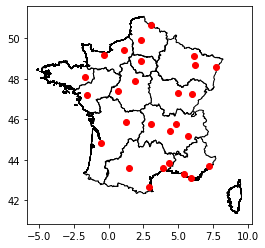

In [40]:
#to solve for a geopandas error
!pip install matplotlib==3.1.3

ax = gdf_FRA_1.plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf_cities.plot(ax=ax, color='red')

plt.show()

In [41]:
#Combining the two tables: cities and regions:
join_cities_df = sjoin(gdf_cities, gdf_FRA_1, how="left")

# Cleaning up the datafram, and only keeping: 
# index, Name, LocalName, GID_1 columns and the geometry:
join_cities_df.drop(join_cities_df.columns.difference(['NAME', 'LocalName', 'geometry', 'GID_1']), 1, inplace=True)
join_cities_df.head()


,NAME,LocalName,geometry,GID_1
0,Amiens,Amiens,POINT (2.30000 49.90000),FRA.7_1
1,Besaneon,Besançon,POINT (6.03330 47.25000),FRA.2_1
2,Bordeaux,Bordeaux,POINT (-0.56660 44.83330),FRA.10_1
3,Caen,Caen,POINT (-0.35000 49.18330),FRA.9_1
4,Clermont-Ferrand,Clermont-Ferrand,POINT (3.08330 45.78330),FRA.1_1


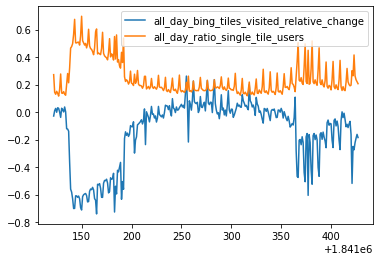

In [42]:
#FRA_df5 = df5[df5['country'] == "FRA"]
#FRA_df5.head()
tmp_FRA_df5 = FRA_df5[FRA_df5['polygon_id'] == "FRA.9_1"]
len(tmp_FRA_df5)
tmp_FRA_df5.plot()

Export dataframes


In [44]:
regions = join_cities_df['GID_1'].unique()
regions

array(['FRA.7_1', 'FRA.2_1', 'FRA.10_1', 'FRA.9_1', 'FRA.1_1', 'FRA.13_1',
       'FRA.6_1', 'FRA.11_1', 'FRA.12_1', 'FRA.4_1', 'FRA.8_1', 'FRA.3_1',
       nan], dtype=object)

In [47]:
tmp_FRA_df5 = FRA_df5[FRA_df5['polygon_id'].isin(regions)]

In [49]:
tmp_FRA_df6 = FRA_df6[FRA_df6['polygon_id'].isin(regions)]
tmp_FRA_df6.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
1068652,2021-01-01,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.58995,0.39422,full_february,DAY_OF_WEEK
1068653,2021-01-02,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.22877,0.26839,full_february,DAY_OF_WEEK
1068654,2021-01-03,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.28481,0.39248,full_february,DAY_OF_WEEK
1068655,2021-01-04,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.12146,0.19961,full_february,DAY_OF_WEEK
1068656,2021-01-05,FRA,GADM,FRA.10_1,Nouvelle-Aquitaine,-0.07696,0.18477,full_february,DAY_OF_WEEK


In [56]:
FRA_HDX_mob = pd.concat([tmp_FRA_df5, tmp_FRA_df6], ignore_index=True)
FRA_HDX_mob.to_csv("FRA_HDX_mob.txt", sep='\t')

join_cities_df.to_csv("FRA_HDX_city.txt", sep='\t')

In [57]:
from google.colab import files
files.download("FRA_HDX_mob.txt")
files.download("FRA_HDX_city.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>